In [1]:
from astropy.table import Table, column
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

In [2]:
# load the data
gz_data = Table.read('../../fits/full_sample_debiased_w_low_z.fits')
print('Loaded GZ data!')
nsa_data = Table.read('../../fits/NSA/nsa_v0_1_2.fits')
print('+ loaded NASA Sloan Atlas data.')

Loaded GZ data!
+ loaded NASA Sloan Atlas data.


In [3]:
# Convert mass from Baldry et al. to Chabrier:
gz_data['mstar_baldry_chabrier'] = gz_data['LOGMSTAR_BALDRY06'] + 0.1

In [4]:
# Remove co-added depth images
normal_depth = ['coadd' not in gz_data['sample'][i] for i in range(len(gz_data))]
normal_depth = np.array(normal_depth)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


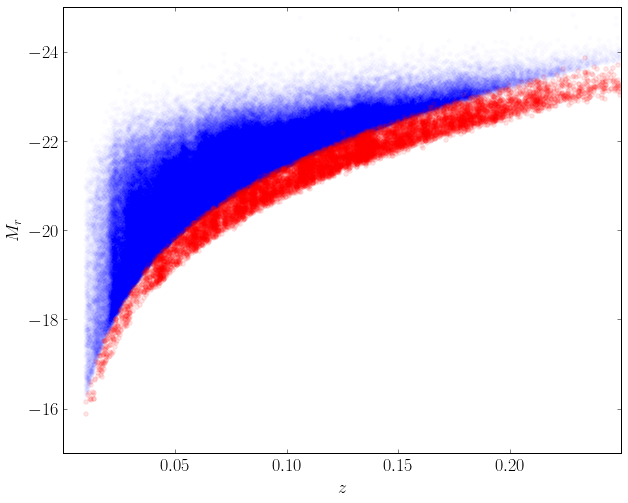

In [5]:
_ = plt.scatter(gz_data['REDSHIFT_1'][normal_depth], gz_data['PETROMAG_MR'][normal_depth]
                ,alpha=0.01,color='b',label='normal depth')

_ = plt.scatter(gz_data['REDSHIFT_1'][normal_depth == False], gz_data['PETROMAG_MR'][normal_depth == False]
                ,alpha=0.1,color='r',label='co-added depth')

# red = co-added depth
# blue = normal depth

plt.axis((0,0.25,-15,-25))
plt.xlabel(r'$z$')
plt.ylabel(r'$M_r$')

# Match the data

In [6]:
import sys
sys.path.append('../../astro_codes/')
#------------------------------------
import volume_limiting
from mass_limiting import get_mass_limit, baldry_equation
import combining_catalogues
import mass_limiting

In [7]:
matches = combining_catalogues.match_sky_restricted(gz_data,nsa_data,1,0.01
                                                    ,['ra_1','dec_1','REDSHIFT_1'],['RACAT','DECCAT','Z'])
# 1" match ^
matched_nsa = combining_catalogues.make_matched_catalogue(gz_data,nsa_data,matches)

248883 galaxies in the reference catalogue
145155 galaxies in the match catalogue
---> 145155 matches in total
---> 65422 unique matches of < 1 arcsec
---> 65349 unique matches of delta-z < 0.01


# Steven: do you know whether these absolute magnitudes look reasonable? -->

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


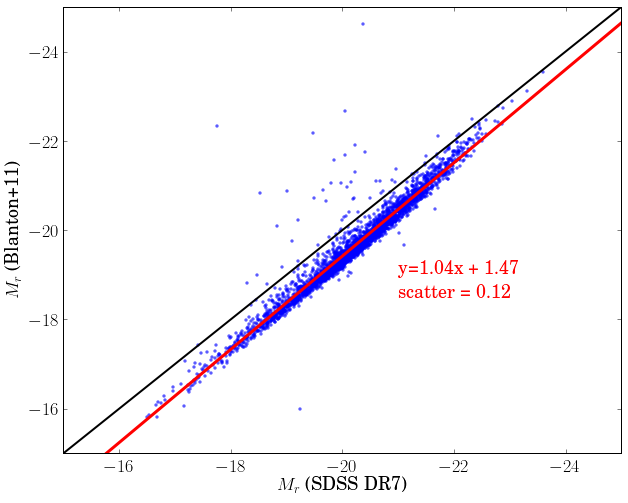

In [78]:
from scipy.optimize import curve_fit

def linear(x,m,c):
    return  m*x + c

def plot_subset(x,y,color='k',alpha=0.75,s=6,N=100,rasterized=True,zorder=0):
    np.random.seed(0)
    subset = np.append(np.ones(N),np.zeros(len(y)-N)).astype(bool) # select only N galaxies
    np.random.shuffle(subset)
    _ = plt.scatter(x[subset],y[subset],color=color,alpha=alpha,s=s,
                    zorder=zorder,rasterized=rasterized)
    return None

x = gz_data['PETROMAG_MR'][mask]
y = matched_nsa['ABSMAG'][:,4][mask]
xy = np.array([x,y]).T
plot_subset(x,y,color='b',N=3000,alpha=0.5)
plt.axis((-15,-25,-15,-25))
plt.plot([-25,-15],[-25,-15],'k',lw=2)
plt.xlabel('$M_r$ (SDSS DR7)')
plt.ylabel('$M_r$ (Blanton+11)')

Mr_fit_paramaters,_ = curve_fit(linear,xy[:,0],xy[:,1])

x_guide = np.linspace(-15,-25,20)
_ = plt.plot(x_guide,linear(x_guide,*Mr_fit_paramaters),'r',lw=3)

plt.text(-21,-19,'y={}x + {}'.format(np.round(Mr_fit_paramaters[0],decimals=2),
                                     np.round(Mr_fit_paramaters[1],decimals=2)),
        color='r')

scatter = np.abs(linear(x,*Mr_fit_paramaters) - y)
#print(np.round(np.median(scatter)),decimals=2)
plt.text(-21,-18.5,'scatter = {}'.format(np.round(np.median(scatter),decimals=2)),color='r')

In [79]:
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

def mag_to_Mag(mag,z):
    D = cosmo.luminosity_distance(z).to(u.pc)
    Mag = mag - 5*(np.log10(D.value)-1)
    return Mag

z_guide = np.linspace(0,0.06,1000)
M_guide_sdss = mag_to_Mag(17,z_guide)
M_guide_nsa = linear(M_guide_sdss,*Mr_fit_paramaters)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


Has WISE detection: 48203/248883 galaxies (19.4%)
z-limited: 45031/248883 galaxies (18.1%)
lum.-limited: 26643/248883 galaxies (10.7%)
-19.3663463639


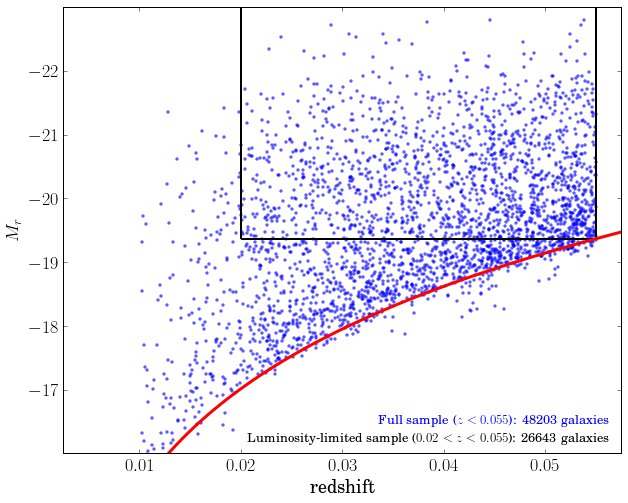

In [127]:
plt.figure(figsize=(10,8))
ax = plt.subplot(111)
xlims = (0.0025,0.0575)
ylims = (-16,-23)

mag_limit_sdss = volume_limiting.get_sample_limits(0.055,17)
mag_limit = linear(mag_limit_sdss,*Mr_fit_paramaters) # mag_limit = for SDSS data; we want the Blanton+11

x, y = [matched_nsa['Z'][mask],matched_nsa['ABSMAG'][:,4][mask]]
plot_subset(x,y,color='b',N=3000,alpha=0.5)

_ = plt.axis((xlims[0],xlims[1],ylims[0],ylims[1]))
plt.vlines(0.02,ylims[1],mag_limit,lw=2,zorder=1)
plt.hlines(mag_limit,0.02,0.055,lw=2,zorder=1)
plt.vlines(0.055,ylims[1],mag_limit,lw=2,zorder=1)

_ = plt.plot(z_guide,M_guide_nsa,color='r',lw=3,zorder=1)

plt.xlabel('redshift')
plt.ylabel('$M_r$')

#---------------------------

def print_sample_size(mask,name):
    y = np.sum(mask)
    t = len(mask)
    print(name + ': {}/{} galaxies ({}%)'.format(y,t,np.round(100*y/t,decimals=1)))


wise_limited = (matched_nsa['mask'] > 0.02) & (chang_in_matched['mask'])
print_sample_size(wise_limited,'Has WISE detection')
redshift_limited = (matched_nsa['Z'] > 0.02) & (chang_in_matched['mask'])
print_sample_size(redshift_limited,'z-limited')
luminosity_limited = (matched_nsa['Z'] >= 0.02) & (matched_nsa['ABSMAG'][:,4] <= mag_limit) & (chang_in_matched['mask'])
print_sample_size(luminosity_limited,'lum.-limited')
print(mag_limit)

_ = plt.text(0.98,0.06,'Full sample ($z < 0.055$): {} galaxies'.format(np.sum(wise_limited)),
             transform=ax.transAxes,ha='right',va='bottom',size=13,color='b')
_ = plt.text(0.98,0.02,'Luminosity-limited sample ($0.02 < z < 0.055$): {} galaxies'.format(np.sum(luminosity_limited)),
             transform=ax.transAxes,ha='right',va='bottom',size=13)

plt.savefig('output_figures/luminosity_limited_sample.pdf')

In [94]:
def Mag_to_lum(Mag,Mag_sun=4.75):
    L = 10**((Mag_sun-Mag)/2.5)
    return L

u_r = gz_data[redshift_limited]['PETROMAG_MU'] - gz_data[redshift_limited]['PETROMAG_MR']
ML = 10**(gz_data[redshift_limited]['LOGMSTAR_BALDRY06'])/Mag_to_lum(gz_data[redshift_limited]['PETROMAG_MR'])

logML = np.log10(ML)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


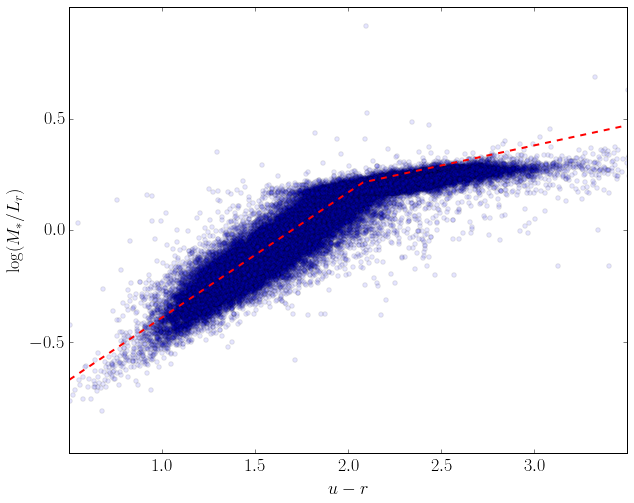

In [18]:
_ = plt.scatter(u_r,logML,alpha=0.1)
_ = plt.axis((0.5,3.5,-1,1))
plt.xlabel('$u-r$')
plt.ylabel('$\log(M_*/L_r)$')

x_guide = np.linspace(0.5,3.5,1000)
y_baldry = []
for x in x_guide:
    y_baldry.append(baldry_equation(x))
y_baldry = np.array(y_baldry)
_ = plt.plot(x_guide,y_baldry,'r--',lw=2)

In [95]:
# Load the WISE masses:
chang_in = Table.read('../../fits/Chang_15/sw_input.fits')
chang_out = Table.read('../../fits/Chang_15/sw_output.fits')

In [97]:
single_detection = chang_out['flag_w'] == 1
print_sample_size(single_detection,'Single optical')
ok_mass = (chang_out['flag_w1'] == 1) | (chang_out['flag_w2'] == 1)
print_sample_size(ok_mass,'Good W1/2 detection')
ok = (single_detection) & (ok_mass)
print_sample_size(ok,'Good overall detection')

chang_in_ok, chang_out_ok = [c[ok] for c in [chang_in,chang_out]]

Single optical: 770900/858365 galaxies (89.8%)
Good W1/2 detection: 846433/858365 galaxies (98.6%)
Good overall detection: 770897/858365 galaxies (89.8%)


In [99]:
chang_matches = combining_catalogues.match_sky_restricted(gz_data,chang_in_ok,max_separation=6,max_dz=0.1,
                                                          reference_xyz=['RA', 'DEC', 'REDSHIFT_1'],
                                                          match_xyz=['ra', 'dec', 'redshift'])

chang_in_matched = combining_catalogues.make_matched_catalogue(gz_data,chang_in_ok,chang_matches)
chang_out_matched = combining_catalogues.make_matched_catalogue(gz_data,chang_out_ok,chang_matches)

248883 galaxies in the reference catalogue
770897 galaxies in the match catalogue
---> 770897 matches in total
---> 193211 unique matches of < 6 arcsec
---> 193146 unique matches of delta-z < 0.1


In [102]:
mask = matched_nsa['mask']
print_sample_size(mask,'NASA Sloan Atlas matched:')
mask = (matched_nsa['mask']) & (chang_in_matched['mask'])
print_sample_size(mask,'NASA Sloan Atlas matched:')

NASA Sloan Atlas matched:: 65349/248883 galaxies (26.3%)
NASA Sloan Atlas matched:: 48203/248883 galaxies (19.4%)


In [128]:
# cross-match comparison w. NSA limited sample

chang_in_zl, chang_out_zl, nsa_data_zl, gz_data_zl = [d[redshift_limited] for d in [chang_in_matched, 
                                                                                    chang_out_matched, 
                                                                                    matched_nsa,
                                                                                    gz_data]]
print_sample_size(chang_out_zl['mask'],'Has Chang mass (z-limited)')

chang_in_vl, chang_out_vl, nsa_data_vl, gz_data_vl = [d[luminosity_limited] for d in [chang_in_matched, 
                                                                                      chang_out_matched, 
                                                                                      matched_nsa,
                                                                                      gz_data]]
print_sample_size(chang_out_vl['mask'],'Has Chang mass (lum.-limited)')

Has Chang mass (z-limited): 45031/45031 galaxies (100.0%)
Has Chang mass (lum.-limited): 26643/26643 galaxies (100.0%)


In [129]:
u_r = nsa_data_zl['ABSMAG'][:,2] - nsa_data_zl['ABSMAG'][:,4]
#ML = 10**(gz_data[redshift_limited]['LOGMSTAR_BALDRY06'])/Mag_to_lum(gz_data[redshift_limited]['PETROMAG_MR'])
logmass = chang_out_zl['lmass50_all']
logLr = np.log10(Mag_to_lum(nsa_data_zl['ABSMAG'][:,4]))
logML = logmass - logLr

44790


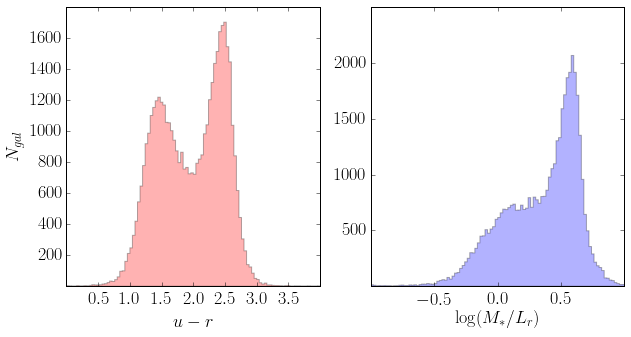

In [130]:
fig, axarr = plt.subplots(1,2,figsize=(10,5))
_ = axarr[0].hist(u_r,bins=np.linspace(0,4,101),histtype='stepfilled',color='r',alpha=0.3)
_ = axarr[1].hist(logML,bins=np.linspace(-1,1,101),histtype='stepfilled',color='b',alpha=0.3)
axarr[0].set_ylabel('$N_{gal}$')
axarr[0].set_xlabel('$u-r$')
axarr[1].set_xlabel('$\log(M_*/L_r)$')

sample_ok = (u_r >= 0.5) & (u_r <= 3.5) & (logML >= -1) & (logML <= 1)
print(np.sum(sample_ok))

In [131]:
from scipy.stats import binned_statistic

def plot_bins(data,i_bins,bins,color='k',alpha=0.5,xlabel=None,ylabel=None,plot=True):
    bin_mean = []
    bin_error = []
    for b, i in enumerate(i_bins):
        select = bins == b+1
        bin_mean.append(np.mean(data[select]))
        bin_error.append(np.std(data[select]))
    bin_mean, bin_scatter = [np.array(u) for u in [bin_mean,bin_error]]
    if plot == True:
        _ = plt.plot(i_bins,bin_mean,lw=3,color=color)
        _ = plt.plot(i_bins,bin_mean-bin_error,linestyle='dashed',
                     color=color,lw=1.5)
        _ = plt.plot(i_bins,bin_mean+bin_error,linestyle='dashed',
                     color=color,lw=1.5)
    
    return bin_mean, bin_scatter

ur_bins, _, bins = binned_statistic(u_r[sample_ok],u_r[sample_ok],bins=np.linspace(0.5,3.5,21),
                                   statistic='median')

/home/ppxrh/anaconda3/lib/python3.4/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


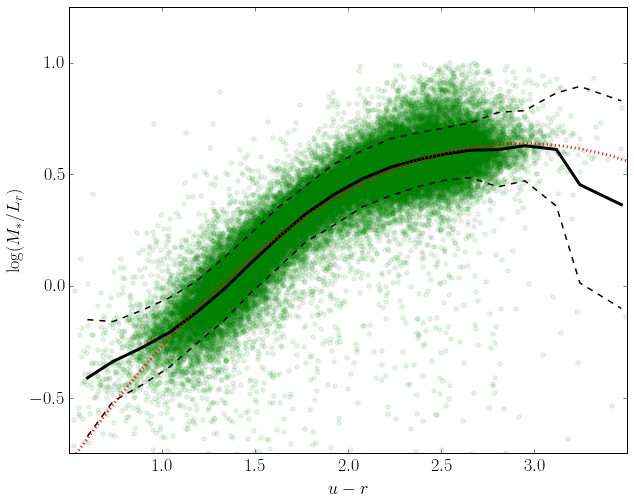

In [150]:
_ = plot_bins(logML[sample_ok],ur_bins,bins,color='k')
_ = plt.scatter(u_r[sample_ok],logML[sample_ok],alpha=0.1,color='g')
plt.axis((0.5,3.5,-0.75,1.25))

xy = np.array([u_r[sample_ok],logML[sample_ok]]).T

from scipy.optimize import curve_fit

def square_function(x,a,b,c,d):
    return a*x**2 + b*x + c 

mass_equation_paramaters,_ = curve_fit(square_function,xy[:,0],xy[:,1])

x_guide = np.linspace(0.5,3.5,1000)
_ = plt.plot(x_guide,square_function(x_guide,*mass_equation_paramaters),'r:',lw=3)

def mass_equation(x):
    return mass_equation_paramaters[0]*x**2 + mass_equation_paramaters[1]*x + mass_equation_paramaters[2]

plt.xlabel('$u-r$')
plt.ylabel('$\log(M_*/L_r)$')

In [ ]:
def get_mass_limit(data,z_limit,mag_limit,mass_equation,low_z_limit=None,column_names=['z','M_r'],
                   colours=['u','r'],Mag_sun=4.67):
    '''
    --- Given a single luminosity limit, calculate the stellar mass-limit ---
    
    Inputs:
    -------
    data: dataset that we wish to stellar mass-limit
    
    z_limit: redshift limit of the volume-limited sample
    
    mag_limit: apparent magnitude limit of the sample (eg. 17.0 for normal depth SDSS).
    
    mass_equation: equation for converting colour -> log(Mass/luminosity) (eg. Baldry+ 2006)
    
    low_z_limit: low redshift cut to apply
    
    column_names: redshift and Magnitude columns for the table.
    
    colours: colour1 and colour2 of the table (eg. u+r Magnitudes for Baldry+ 2006)
    
    Mag_sun: absolute magnitude of the sun (to get luminosity in solar luminosities). For 
    the SDSS r-band, this value is 4.67.
    
    Outputs:
    --------
    logmass: log stellar mass limit.
    '''
    
    z_column, Mag_column = column_names
    colour = data[colours[0]] - data[colours[1]]
    
    if low_z_limit != None:
        in_z_min = data[z_column] >= low_z_limit
    else:
        in_z_min = np.full(len(data), True, dtype=bool)
    
    Mag_limit_sdss = volume_limiting.get_sample_limits(z_limit,17)
    Mag_limit = linear(Mag_limit_sdss,*Mr_fit_paramaters) # mag_limit = for SDSS data; we want the Blanton+11
    in_z_max = data[z_column] <= z_limit
    in_Mag_limit = data[Mag_column] <= Mag_limit
    in_volume_limit = (in_z_min) & (in_z_max) & (in_Mag_limit)
    vl_colour = colour[in_volume_limit]
    colour_99 = np.percentile(vl_colour,99,axis=0)
    log_ML = mass_equation(colour_99)
    lum_limit = Mag_to_lum(Mag_limit)
    mass_limit = lum_limit*(10**(log_ML))
    logmass = math.log10(mass_limit)

    return logmass

In [ ]:
nsa_data_zl['M_u'] = nsa_data_zl['ABSMAG'][:,2]
nsa_data_zl['M_r'] = nsa_data_zl['ABSMAG'][:,4]

mass_limit_max_z = get_mass_limit(nsa_data_zl,z_limit=0.055,mag_limit=17,mass_equation=mass_equation
                                  ,column_names=['Z','M_r'],colours=['M_u','M_r'])

In [ ]:
z_values = np.linspace(0.021,0.055,101)
mass_limits = []

for z in z_values:
    mass_limit = get_mass_limit(nsa_data_zl,z_limit=z,mag_limit=17,mass_equation=mass_equation
                                ,column_names=['Z','M_r'],colours=['M_u','M_r'])
    mass_limits.append(mass_limit)
    
mass_limits = np.array(mass_limits)

In [ ]:
_ = plt.axis((0.015,0.06,8,12))

def log_function(x,a,b):
    return a*np.log10(x) + b

x_guide = np.linspace(0.015,0.06)

xy = np.array([z_values,mass_limits]).T

mass_limit_paramaters, _ = curve_fit(log_function,xy[:,0],xy[:,1])

_ = plt.plot(x_guide,log_function(x_guide,*mass_limit_paramaters),color='k',lw=2)
_ = plt.scatter(nsa_data_zl['Z'],chang_out_zl['lmass50_all'],color='g',alpha=0.1)
plt.xlabel('redshift')
plt.ylabel('$\log (M_*)$')

In [ ]:
# get spirals:
import make_dictionaries
questions = make_dictionaries.questions

p_spiral = (gz_data['t01_smooth_or_features_a02_features_or_disk_debiased_rh']*
            gz_data['t02_edgeon_a05_no_debiased_rh']*
            gz_data['t04_spiral_a08_spiral_debiased_rh'])

N_spiral = (gz_data['t04_spiral_a08_spiral_count'] - 
            gz_data['t11_arms_number_a37_cant_tell_count'])

p_ok = p_spiral > 0.5
N_ok = N_spiral >= 5
in_spiral = (p_ok) & (N_ok)

question = 't11_arms_number'
answers = questions[question]['answers'][:-1]
answer_array = np.array([gz_data[question + '_' + A + '_debiased_rh'].data for A in answers]).T
m = np.argmax(answer_array,axis=1)

In [ ]:
# finally, make the required samples/look at sample sizes:
redshift_limited = (matched_nsa['Z'] >= 0.02)
print_sample_size(redshift_limited,'z-limited')
luminosity_limited = (matched_nsa['Z'] >= 0.02) & (matched_nsa['ABSMAG'][:,4] <= mag_limit)
print_sample_size(luminosity_limited,'lum.-limited')
mass_limited = (luminosity_limited) & (chang_out_matched['lmass50_all'] > mass_limit_max_z)
print_sample_size(mass_limited,'M*-limited')
vmax_limited = (redshift_limited) & (chang_out_matched['lmass50_all'] 
                                     > log_function(matched_nsa['Z'],*mass_limit_paramaters))
print_sample_size(vmax_limited,'Vmax-limited')

In [ ]:
in_samples = Table()
in_samples['in_z_limit'] = redshift_limited
in_samples['in_lum_limit'] = luminosity_limited
in_samples['in_mass_limit'] = mass_limited
in_samples['in_vmax_limit'] = vmax_limited
in_samples['in_spiral'] = in_spiral
in_samples['m'] = m

In [ ]:
redshift_limited = (matched_nsa['Z'] >= 0.02) & (in_spiral)
print_sample_size(redshift_limited,'z-limited')
luminosity_limited = (matched_nsa['Z'] >= 0.02) & (matched_nsa['ABSMAG'][:,4] <= mag_limit) & (in_spiral)
print_sample_size(luminosity_limited,'lum.-limited')
mass_limited = (luminosity_limited) & (chang_out_matched['lmass50_all'] > mass_limit_max_z) & (in_spiral)
print_sample_size(mass_limited,'M*-limited')
vmax_limited = ((redshift_limited) & (chang_out_matched['lmass50_all'] 
                                      > log_function(matched_nsa['Z'],*mass_limit_paramaters)) & (in_spiral))
print_sample_size(vmax_limited,'Vmax-limited')

In [ ]:
# For each galaxy, calculate its 'mass weighting'

def inverse_mass_function(mass,mass_error,a,b):
    zmax = 10**((mass-b)/a)
    zmax_error = (zmax/a)*mass_error
    return zmax, zmax_error

def get_mass_weighting(mass,mass_error,max_z=0.055,min_z=0.02):
    zmax,z_error = inverse_mass_function(mass,mass_error,*mass_limit_paramaters)
    zmax[mass < 0] = -999
    zmax[zmax >= max_z] = max_z
    mass_weighting = (1/(zmax**3-min_z**3))/(1/(max_z**3-min_z**3))
    return zmax, mass_weighting, z_error

In [ ]:
masses = chang_out_matched[vmax_limited]['lmass50_all']
mass_errors = (chang_out_matched[vmax_limited]['lmass84_all']-chang_out_matched[vmax_limited]['lmass16_all'])/2

zmax, mass_weighting, z_error = get_mass_weighting(masses, mass_errors)
z = matched_nsa[vmax_limited]['Z']

In [ ]:
bad_z = 3*z_error > (zmax-0.02)

_ = plt.hist(np.log10(mass_weighting),histtype='stepfilled',
             color='y',alpha=0.5,bins=np.linspace(0,2.2,45))

_ = plt.hist(np.log10(mass_weighting[bad_z]),histtype='stepfilled',
             color='k',alpha=0.5,bins=np.linspace(0,2.2,45))

plt.yscale('log')
plt.xlabel('$\log\mathrm{(weight)}$')
plt.ylabel('$N_\mathrm{gal}$')